In [32]:
import numpy as np

from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import ParameterGrid

from scipy.stats import norm

import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(1)

## Define some multivariate function

In [2]:
def target(x, p, q, r):
    return np.exp(-(x - p)**2) + np.exp(-(x - q)**2/r) + 1/ (x**2 + 1)

### Plot some configurations

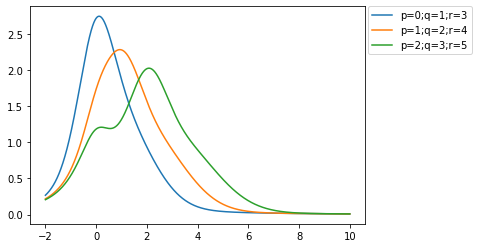

In [69]:
x = np.linspace(-2, 10, 10000).reshape(-1, 1)
for p, q, r in zip(range(0, 3), range(1,5), range(3,7)):
    y = target(x, p, q, r)
    plt.plot(x, y, label=f"p={p};q={q};r={r}")
plt.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

## Define boundaries

In [4]:
BOUNDS = {
    'x': (-2, 10),
    'p': (0, 3),
    'q': (1, 5),
    'r': (3, 7),
}

In [5]:
gp = GaussianProcessRegressor(
    kernel=Matern(nu=2.5),
    alpha=1e-6,
    normalize_y=True,
    n_restarts_optimizer=5,
)


## Get some random points

In [6]:
INIT_POINTS=8
X = np.asarray(
    [[np.random.uniform(lb,rb) for _ in range(INIT_POINTS)] for _, (lb, rb) in BOUNDS.items() ]
)

# Evaluate target in those points

In [8]:
y = np.asarray([target(*p) for p in X.T])

## Fit Gaussan Process regressor

In [9]:
gp.fit(X.T, y)

GaussianProcessRegressor(alpha=1e-06, copy_X_train=True,
             kernel=Matern(length_scale=1, nu=2.5), n_restarts_optimizer=5,
             normalize_y=True, optimizer='fmin_l_bfgs_b',
             random_state=None)

## Sample GP in x axis
let's sample N points over whole range in parameter x and constant others

In [38]:
N_SAMPLES=100
params = list(ParameterGrid({
    "x": np.linspace(*BOUNDS["x"], N_SAMPLES, True),
    "p": [X[1,0]],
    "q": [X[2,0]],
    "r": [X[3,0]],
}))
x = np.asarray(
    [[p[k] for k in BOUNDS.keys()] for p in params]
)

In [39]:
%time
mean, std = gp.predict(x, return_std=True)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.87 µs


## Calculate Expected Improvement

In [67]:
z = (mean - max(y)) / std
ei = mean * norm.cdf(z) + std * norm.pdf(z)

## Plot predicted function and confidence

-- Note that, for sake of simplicity, we are sampling only in x axis, but the problem is multidimensional (target approximation should vary)

In [68]:
_x = np.linspace(*BOUNDS["x"], N_SAMPLES, True)
# calculate true target
_y = np.asarray([target(*p) for p in x])

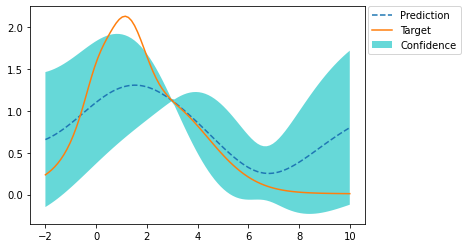

In [64]:
plt.plot(_x, mean, "--", label="Prediction")
plt.plot(_x, _y, "-", label="Target")
plt.fill(np.concatenate([_x, _x[::-1]]), np.concatenate([mean-std, (mean+std)[::-1]]),alpha=.6, fc='c', ec='None', label="Confidence")
plt.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

## Plot expected Improvement and Upper confidence bound

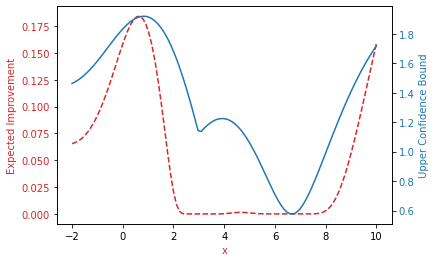

In [78]:
fig, ax1 = plt.subplots()
ax1.plot(_x, ei, "--", label="Expected Improvement", color="tab:red")
ax1.set_xlabel("x", color="tab:red")
ax1.set_ylabel("Expected Improvement", color="tab:red")
ax1.tick_params(axis='y', labelcolor="tab:red")

ax2=ax1.twinx()
ax2.plot(_x, mean+std, "-", label="Upper Confidence Bound", color="tab:blue")
ax2.set_xlabel("x", color="tab:blue")
ax2.set_ylabel("Upper Confidence Bound", color="tab:blue")
ax2.tick_params(axis='y', labelcolor="tab:blue")


##

From now on, the problem is to choose points in space of parameters that maximize either Expected Improvement or Upper Confidence Bound. The original method used some random seed followed by "L-BFGS-B" optimization from scikit.